# **Class Imbalance using imblearn**

##### **We will discuss our class imbalance problem amongst our target variable 'isFraud'. Class imbalance problems often occur in these problems regarding fraudulent transaction identification and spam identification.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

### **The metric trap:**
One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.


Some Metrics that can provide better insight than just accuracy include:

* **Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.

* **Precision**: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

* **Recall**: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

* **F1 Score**: the weighted average of precision and recall.

We will also be using a **Precision-Recall** curve, since there is a significant class imabalance between our feature and target variables.

### **Loading in and sorting the data after Feature Engineering**

In [ ]:
df = pd.read_csv('full_data.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### **Reducing memory usage (.py function)**

In [ ]:
from memory_reduction import reduce_mem_usage

In [ ]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1347.76 MB
Memory usage after optimization is: 299.27 MB
Decreased by 77.8%


In [ ]:
df.shape

(1097231, 161)

**Resorting df to updated train and test datasets**

In [ ]:
train, test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

#Dropping extra index column added when parsing
train, test = train.drop('Unnamed: 0',axis=1) , test.drop('Unnamed: 0',axis=1)

#Converting all values of isFraud to numeric values of 0 or 1
train['isFraud'] = train['isFraud'].apply(pd.to_numeric, errors='ignore')

print(train.shape)
print(test.shape)

(590540, 160)
(506691, 159)


#### **Looking at the distibution of target variable 'isFraud' in training set**

The percentage of fraudulent transactions in the training data set is 3.499 %
Class Ratio: 0.03499

There is a significant CLASS IMBALANCE probelem that must be addressed.


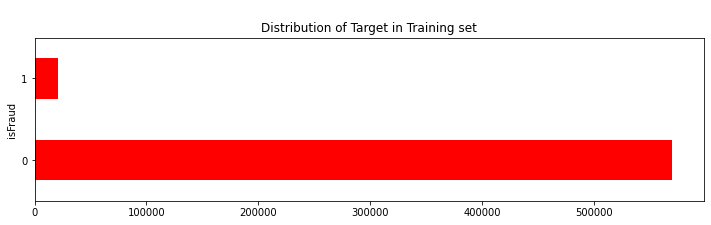

In [ ]:
print('The percentage of fraudulent transactions in the training data set is', round(train['isFraud'].sum()/len(train['isFraud']) * 100,4),'%')
print('Class Ratio:', round(sum(train['isFraud']/len(train['isFraud'])),5))
print('\nThere is a significant CLASS IMBALANCE probelem that must be addressed.')

train.groupby('isFraud').count()['TransactionID'].plot(kind='barh',
                                                      title='\nDistribution of Target in Training set', color='r',figsize=(12, 3))
plt.show()


**Sorting X_train, y_train, and X_test by TransactionDT, timedelta feature**

In [ ]:
X_train = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', ],axis=1)
#y_train = train.sort_values('TransactionDT')['isFraud'].astype(bool)
y_train = train.sort_values('TransactionDT')['isFraud']

X_test = test.sort_values('TransactionDT').drop(['TransactionDT', ], axis=1)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

del train
test = test[["TransactionDT"]]

X_train shape: (590540, 158)
y_train shape: (590540,)
X_test shape: (506691, 158)


**Cleaning X_train, y_train, and X_test datasets by replacing NaN values with -999**

In [ ]:
X_train.fillna(-999, inplace=True)
y_train.fillna(-999, inplace=True)
X_test.fillna( -999, inplace=True)

## **Resampling methods** *(Over/ Undersampling for Class imbalance)*
* **We will only be applying these resampling methods on the training dataset**

1. **Oversample minority class**
2. **Undersample majority class**
3. **Random over-sampling with python module: imbalanced-learn (This is what we will be using for our final dataset to prepare it for modeling)** 

In [ ]:
# Joining our X_train and y_train data to perform resampling
full = pd.concat([X_train,y_train],axis=1)
not_fraud = full[full.isFraud==0]
fraud = full[full.isFraud==1]

### **1. Oversampling the minority class**

* Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.
* We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class (isFraud).

In [ ]:
# 1. Oversampling the minority class

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.isFraud.value_counts()

1    569877
0    569877
Name: isFraud, dtype: int64

### **2. Undersampling the majority class**
* Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.
* We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class. This method is not paticularly useful in our case, since we want to **increase** instances of the the target variable 'isFraud', which is the minority class.

In [ ]:
# 2. Undersampling the majority class

#downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts (1- True, 0- False)
downsampled.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

## **IMBLEARN:**
* imblearn is a much more sophisticated resampling technique. Using imblearn we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

### **3. Random Over-sampling with imblearn**
* #### **This is the method we will be using for our training dataset, as we want to increase instances of isFraud = 1, which will be achieved by oversampling the minority class of the target variable.**


In [ ]:
import imblearn
from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Distribution prior to resampling 
print('Distribtuion prior sampling: ', Counter(y_train))

oversample = RandomOverSampler(sampling_strategy='minority')

X_samp, y_samp = oversample.fit_resample(X_train,y_train)

# Distribution after resmpling
print('Distribution after sampling: ', Counter(y_samp))

print('\nThe new data now contains {} rows '.format(X_samp.shape[0]))

# Plotting the new vs. old distributions of the training data
#plot_2d_space(X_rand,y_rand, X_train.ravel(), y_train, 'Random over sampling')

Distribtuion prior sampling:  Counter({0: 569877, 1: 20663})
Distribution after sampling:  Counter({0: 569877, 1: 569877})

The new data now contains 1139754 rows 


In [ ]:
X_resampled = pd.DataFrame(X_samp, columns=X_train.columns)
y_resampled = pd.DataFrame(y_samp).rename(columns = {0: 'isFraud'})
X_resampled.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D14,D15,M1,...,C1_to_mean_addr2,C1_to_std_addr2,C1_to_mean_dist1,C1_to_std_dist1,C2_to_mean_addr1,C2_to_std_addr1,C2_to_mean_addr2,C2_to_std_addr2,C2_to_mean_dist1,C2_to_std_dist1,PCA_V_0,PCA_V_1,PCA_V_2,PCA_V_3,PCA_V_4,PCA_V_5,PCA_V_6,PCA_V_7,PCA_V_8,PCA_V_9,PCA_V_10,PCA_V_11,PCA_V_12,PCA_V_13,PCA_V_14,PCA_V_15,PCA_V_16,PCA_V_17,PCA_V_18,PCA_V_19,PCA_V_20,PCA_V_21,PCA_V_22,PCA_V_23,PCA_V_24,PCA_V_25,PCA_V_26,PCA_V_27,PCA_V_28,PCA_V_29
0,2987000.0,4.226562,4.0,3417.0,500.0,42.0,1.0,38.0,1.0,166.0,65.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,0.0,1.0,...,0.104919,0.019379,0.120422,0.036011,0.130859,0.029251,0.110535,0.018448,0.134644,0.040741,0.374756,0.909180,0.159180,0.896973,0.189331,-0.027542,0.031525,-0.173096,0.014000,0.024216,-0.018219,-0.034332,-0.123291,0.013222,-0.014397,0.076172,0.032654,0.012947,-0.012138,-0.008698,-0.005699,-0.002466,0.018723,-0.005238,0.006531,-0.045319,-0.034210,-0.053741,0.026672,-0.060516
1,2987001.0,3.367188,4.0,7922.0,303.0,42.0,2.0,2.0,1.0,173.0,65.0,-999.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,2.0,...,0.104919,0.019379,-1.000000,-1.000000,0.124390,0.021454,0.110535,0.018448,-1.000000,-1.000000,-0.057159,-0.172119,0.629883,0.453125,-0.438477,0.038239,-0.096375,-0.050079,0.000414,0.005173,0.077026,-0.130981,-0.085510,-0.043732,-0.016922,0.015350,0.003777,0.017746,-0.012070,0.001741,-0.039368,0.003017,0.012375,-0.002649,-0.004078,0.008934,0.029266,0.029114,-0.023621,-0.037689
2,2987002.0,4.078125,4.0,9383.0,389.0,42.0,4.0,58.0,2.0,178.0,65.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,315.0,-999.0,-999.0,315.0,1.0,...,0.104919,0.019379,0.456299,0.753418,0.116455,0.017685,0.110535,0.018448,0.567871,0.957520,-0.347168,0.210938,0.766602,0.227051,0.069214,-0.025726,0.083496,-0.176514,0.059845,0.017334,-0.021301,-0.012100,0.003212,0.010880,-0.042267,0.017624,-0.011185,-0.001363,-0.016678,-0.000590,-0.009560,0.002848,-0.003054,0.002321,-0.005459,-0.001485,-0.000145,0.001475,0.004406,0.000626
3,2987003.0,3.912109,4.0,6991.0,466.0,42.0,2.0,14.0,2.0,282.0,65.0,-999.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,84.0,-999.0,-999.0,-999.0,111.0,2.0,...,0.209839,0.038757,-1.000000,-1.000000,0.685547,0.101257,0.552734,0.092224,-1.000000,-1.000000,-0.190918,-0.130981,0.684082,0.438232,-0.424805,0.055695,-0.041962,-0.176880,0.165771,0.064514,-0.032745,0.140625,0.035736,-0.043671,-0.014610,-0.023804,-0.026154,0.034119,0.134399,-0.053589,0.063416,0.024902,0.013138,0.026688,-0.002556,0.027267,0.053802,0.033844,-0.015182,-0.017883
4,2987004.0,3.912109,1.0,9262.0,413.0,42.0,2.0,2.0,1.0,241.0,65.0,-999.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.0,...,0.104919,0.019379,-1.000000,-1.000000,0.116882,0.013092,0.110535,0.018448,-1.000000,-1.000000,2.810547,-0.055969,0.622070,-0.219727,0.266602,1.117188,-0.074158,-0.132202,-0.293945,-0.086243,-0.016876,0.077637,-0.168579,0.015015,-0.001257,0.004368,-0.000573,-0.020493,0.006176,-0.011879,0.013397,-0.011978,0.007103,0.074768,0.026657,0.023148,-0.041290,-0.004898,-0.000383,0.008095


## **SAVE resampled data for modeling**

**Training dataset**

In [ ]:
X_resampled.to_csv('X_train.csv')
y_resampled.to_csv('y_train.csv')

**Testing dataset**

In [ ]:
X_test.to_csv('X_test.csv')